In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sl

In [11]:

df = pd.read_csv('./bench_20240118_180013_timestep_0_psrn_by_tol.csv')
df.head()

,tol,oriSize,compressedsize,psnr,max_error,rmse,comp_ratio,method,time
0,0.00001,67108864,36846931,115.992338,0.000015,0.000002,1.821288,MGARD,0.240559
1,0.00000,67108864,33554432,84.190197,0.000976,0.000075,2.000000,numpy,0.083516
2,0.00005,67108864,22585275,102.012117,0.000080,0.000010,2.971355,MGARD,0.232994
3,0.00000,67108864,33554432,84.190197,0.000976,0.000075,2.000000,numpy,0.083423
4,0.00010,67108864,19098419,95.991609,0.000152,0.000019,3.513844,MGARD,0.231923


In [13]:
df["tol"]

0     0.00001
1     0.00000
2     0.00005
3     0.00000
4     0.00010
5     0.00000
6     0.00050
7     0.00000
8     0.00100
9     0.00000
10    0.00500
11    0.00000
12    0.01000
13    0.00000
14    0.02000
15    0.00000
16    0.03000
17    0.00000
18    0.05000
19    0.00000
20    0.10000
21    0.00000
22    0.50000
23    0.00000
24    1.00000
25    0.00000
Name: tol, dtype: float64

In [39]:
net = 1000
networkBw = net #MiB/sec
data_Size = 64 #MiB

In [40]:
mgard = df[(df["oriSize"] ==67108864) & (df["method"] == "MGARD")]
fp16 = df[(df["oriSize"] ==67108864) & (df["method"] == "numpy")]

comp_ratio = mgard["comp_ratio"]
psnr =  mgard["psnr"]
comp_and_decomp_time = mgard["time"]
MGARD_total_time = comp_and_decomp_time + data_Size/np.array(comp_ratio.values)/networkBw

fp16_comp_ratio = 2.0
fp16_psnr = 84.1901969909668

In [41]:
fp16_comp_ratio = 2.0
fp16_psnr = 86.369534
fp16_comp_and_decomp_time = 8.65
data_Size = 64
fp16_total_time = data_Size/fp16_comp_ratio/networkBw + fp16_comp_and_decomp_time

In [42]:
# no cmp

no_comp_time = data_Size/networkBw
print(no_comp_time)

0.064


In [43]:

# cuSZp_tol = [0.1, 0.01, 0.001,0.0005, 0.0001, 0.00005, 0.00001, 0.000001]
cuSZp_tol = [0.06, 0.01, 0.001,0.0005, 0.0001, 0.00005, 0.00001, 0.000001]
cuSZp_psnr = [30.66,44.77,64.77,70.792,84.77,90.79,104.77,124.76]
cuSZp_comp_ratio = [18.616,9.631096,5.1531, 4.4569,3.3770,3.055,2.50,1.985]
cuSZp_comp_time = [0.015,0.0140,0.016,0.016,0.017,0.018,0.017,0.019]
cuSZp_decomp_time = [0.018,0.020, 0.0230,0.023,0.024,0.025,0.024,0.027]

cuSZp_comp_and_decomp_time = np.add(np.array(cuSZp_comp_time) ,np.array(cuSZp_decomp_time))
cuSZp_total_time = np.array(cuSZp_comp_and_decomp_time) + data_Size/np.array(cuSZp_comp_ratio)/(networkBw)



In [44]:
cuSZp_total_time

array([0.0364379 , 0.04064514, 0.05141971, 0.05335976, 0.05995173,
       0.06394926, 0.0666    , 0.07824181])

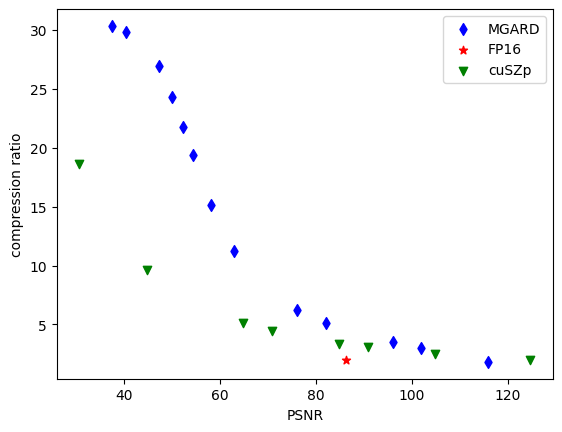

In [45]:
plt.scatter(psnr, comp_ratio, label='MGARD', marker='d', color='blue',)
plt.scatter(fp16_psnr, fp16_comp_ratio,label="FP16",color="red",marker='*')
plt.scatter(cuSZp_psnr,cuSZp_comp_ratio,label="cuSZp",color="green",marker='v')
plt.ylabel("compression ratio")
plt.xlabel("PSNR")
plt.legend()
plt.savefig(f"szVsMGARDvsFP16_inverseSize_{data_Size}",dpi=300)

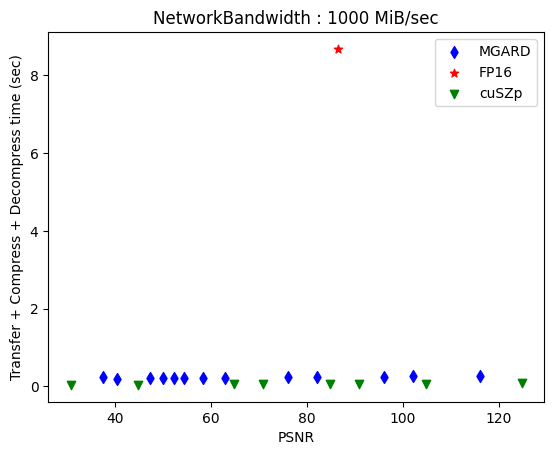

In [46]:
# total_time vs PSNR
plt.scatter(psnr, MGARD_total_time, label='MGARD', marker='d', color='blue')
plt.scatter(fp16_psnr,fp16_total_time, label="FP16",color="red",marker='*')
plt.scatter(cuSZp_psnr,cuSZp_total_time,label="cuSZp",color="green",marker='v')
# plt.hlines(no_comp_time, xmin=40, xmax=130, color='red', linestyle='--', label='No Comp Time')
plt.xlabel("PSNR")
plt.ylabel("Transfer + Compress + Decompress time (sec)")
plt.title(f"NetworkBandwidth : {net} MiB/sec")
plt.legend()
plt.savefig(f"szVsMGARDvsFP16_speed_net_{net}.png",dpi=300)

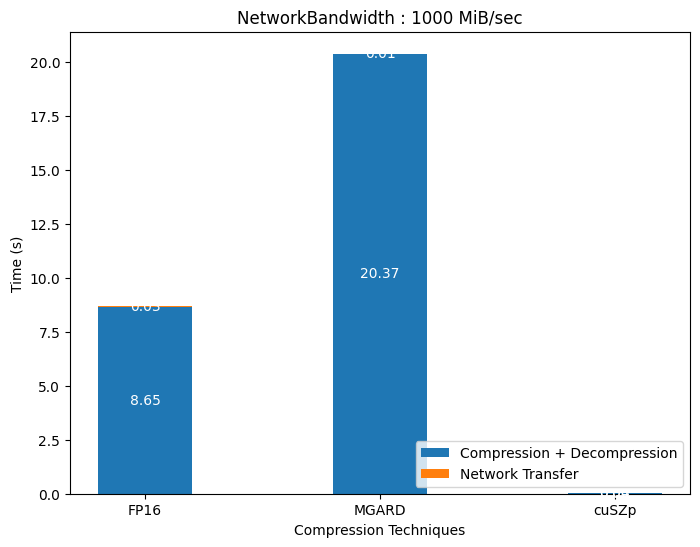

In [29]:
# stacked bar chart for PSNR arund 85's result 
# format = [compression+decomp, transfer_time]
fp16_detail = [8.65,data_Size/fp16_comp_ratio/networkBw]
mgard_detail = [20.371768,data_Size/5.579996/networkBw]
cuSZp_detail = [cuSZp_comp_and_decomp_time[4], 4/cuSZp_comp_ratio[4]/networkBw]


# Labels for the bars
labels = ['FP16', 'MGARD', 'cuSZp']

# Values for the first stacked bar
values1 = [fp16_detail[0], mgard_detail[0], cuSZp_detail[0]]

# Values for the second stacked bar
values2 = [fp16_detail[1], mgard_detail[1], cuSZp_detail[1]]

# X-axis positions for the bars
x = range(len(labels))

# Create the stacked bar chart
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x, values1, label='Compression + Decompression', width=0.4)
bars2 = plt.bar(x, values2, bottom=values1, label='Network Transfer',width=0.4)

# Add numbers inside the bars
for bar1, bar2, value1, value2 in zip(bars1, bars2, values1, values2):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() / 2, f'{value1:.2f}', ha='center', va='center', color='white', fontsize=10)
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar1.get_height() + bar2.get_height() / 2, f'{value2:.2f}', ha='center', va='center', color='white', fontsize=10)


# Customize the plot
plt.xlabel('Compression Techniques')
plt.ylabel('Time (s)')
plt.title(f"NetworkBandwidth : {net} MiB/sec")
plt.xticks(x, labels)
plt.legend()


plt.savefig(f"szVsMGARDvsFP16_speed_detail_at_psnr84Net_{net}.png",dpi=300)
# Show the plot
plt.show()


In [17]:
# time for compression and quantimization
df.head()


,tol,oriSize,compressedsize,psnr,comp_ratio,is_quantimized,time
0,0.00001,1073741824,516612451,117.393399,2.077659,No,2.771015
1,0.00000,2147483648,536672250,85.523682,2.000000,Yes,2.145995
2,0.00001,2147483648,1042579859,118.175915,2.054087,No,5.368383
3,0.00000,4294967296,1070774656,86.369534,2.000000,Yes,4.287386
4,0.00001,4294967296,2766447413,124.477385,1.547977,No,16.729396


In [ ]:
mgard = df[(df["is_quantimized"] == "No")]
fp16 = df[(df["is_quantimized"] == "Yes")]